Transformers are getting more and more important not just in NLP but now its going to extend its surface area into other areas of deep learning beyond just language. Google has rolled out BERT and transformer based models to google search, they have been using them to empower google search and they call it one of the biggest leaps forward in the the history of search.


In this notebook,  we’ll focus on one paper that started it all, [Attention is all you need!](https://arxiv.org/abs/1706.03762v5)

Below is the architecture of the model as mentioned in the paper.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

On a highlevel, like any RNN based and CNN based sequence to sequence structure, Transformers is composed of an encoder and a decoder. The encoder converts the original input sequence into its latent representation in the form of hidden state vectors. The decoder tries to predict the output sequence using this latent representation.
 
The input (source) and output (target) sequence embeddings are added with positional encoding before being fed into the encoder and the decoder. The encoding component is a identical stack of encoders and the decoding component is a identical stack of decoders of the same number, the paper used 6 stacks but we will be using only 3 stacks of encoder and decoder layers.

Each encoder consists of two sub layers
- a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word. 
- a feed-forward neural network , the exact same feed-forward network is independently applied to the word in each position through its own path in the encoder, hence it is called postion wise feed forward neural network.

The decoder also has self attention and feed forward layers, but between them is another attention layer that helps the decoder focus on relevant parts of the input sentence

Now that we’ve seen the highlevel components of the model, we will deep dive and further understand each of these individual components in detail.

## Data Processing 
The first step towards any machine learning is input data processing, the input in our case is going to be the German Sentence. However, computers don't understand text the only language they understand is of matrices and numbers, we will therefore have to transform the input text into numbers. 

So to do that, first we take all the words present in the training data and create a vocabulary out of it. If our training data is as big as a wikipedia, our vocabulary can be composed of all the words in english language.
Next, we assign a numeric index next to each word and then we pick only the words that occur in the current input text. Therefore, what gets fed into the transformer are not the german/english words but their corresponding indices.

In next few blocks lets first, preprocess and prepare the data before we feed it to the transformer model.

In [ ]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 26.9MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


## Import Modules

First, we'll import all the modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

Next, we'll set the random seed for reproducability. Till the kernel is alive, the seed is a valid. If we shutdown the kernel the seed will be reset, next time when the kernel is restart we will not be able to reproduce same result.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 27.4MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=527c4a633482f70ef0901f0c7cf8673560ffb14475d406474b3c993ef399af34
  Stored in directory: /tmp/pip-ephem-wheel-cache-s7hotr8i/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is a token, not a word.

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

Note: the models must first be downloaded using the following on the command line:

    python -m spacy download en
    python -m spacy download de

We load the models as below:

In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

TorchText's Fields handle how data should be processed.

We set the tokenize argument to the correct tokenization function for each, with German being the SRC (source) field and English being the TRG (target) field. The field also appends the "start of sequence" and "end of sequence" tokens via the init_token and eos_token arguments, and converts all words to lowercase, batch_first is set to True so that TorchText can return the tensors of dimension [batch size, sequence length].

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Next, we download and load the train, validation and test data.

The dataset we'll be using is the Multi30k dataset. This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence.

exts specifies which languages to use as the source and target (source goes first) and fields specifies which field to use for the source and target.

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 962kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 274kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 266kB/s]


Then create our vocabulary, converting all tokens appearing less than twice into tokens.

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

We also need to define a torch.device. This is used to tell TorchText to put the tensors on the GPU or not. We use the torch.cuda.is_available() function, which will return True if a GPU is detected on our computer.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a src attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a trg attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

When we get a batch of examples using an iterator, we use a BucketIterator instead of the standard Iterator as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences.

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Encoder
Let's now have a closer look at the Encoder structure.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

Once the data is prepared these inputs are passed on to the next layer, that is the embedding layer.
The embedding layer too has an index for every word in the vocabulary and against each of those indices a vector is attached, initially these vectors are filled up with random numbers. Later on during training phase the model updates them with values that better help them with the assigned task.

The transformer paper, have gone with the embedding size of 512 and we will use the same here.

### So what are word embeddings?

Well, these are just vector representation of a given word. Each dimension on word embeddings tries to capture about some concept or linguistic feature of that word, these could be things like whether the word is a verb, preposition, or an entity or something else.But in reality since the model decides these features itself during training, it could be difficult to find out exactly what information do each of these dimensions represent.

Graphically, the values of these dimensions represent the coordinates of the given word in some hyperspace. If two words share similar linguistic features and appear in similar contexts their embedding values are updated to become closer and closer during the training process. 

For example consider these two words 'King' and 'Queen', initially their embeddings are randomly initialized but during the course of training they may become more and more similar since these two words often appear in similar context. This is when compared to the word 'School' that often appears in a whole different context. Hence the embedding layer selects the embedding corresponding to the input text and passes them further on.
The embedding layer takes input indicies and converts them into word embeddings then these get passed further on to the next layer, the positional embeddings.

###  Positional embeddings, why do we need them?

If RNNs were to take up these embeddings it would do so sequentially, one embedding at a time, which is why they are so slow. There is a positive side to this however, since RNNs take the embeddings sequentially in the designated order they know which word came first which word came second and so on . Transformers on the other hand take up all embeddings at once. Now, even though this is a huge plus and makes transformers  much faster the down side is that they loose the critical information related to word ordering. In simple words, they are not aware of which word came first in the sequence and which word came last, here's why positional information matters.

`Even though she did not win the award, she was satisfied.`

`Even though she did win the award, she was not satisfied.`

Notice how the position of the single word `not`, not only changed the sentiment but also the meaning of the sentence.So what do we do to bring back the order information to the transformers without having to make them recurrent like RNNs.
How about we introduce a new set of vectors containing the position information? Let us call them position embeddings.

We can start by simply adding the word embeddings to their corresponsing position embeddings and create a new order aware word embedings. But what values should our position embeddings contain, we start by literally filling in the word position numbers so the first postion embeddings has zeros, the next has all one's and so on. 

Before summing up with the position embedding, the token embeddings are multiplied by a scaling factor, which is square root of hidden dimension. This helps reduce variance in the embeddings. Dropout is then applied to the combined embeddings.

The combined embeddings are further passed on to the Encoding Layer along with the src_mask.
The src_mask (source mask), is the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens as it doenot contain any useful information. 



In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

## Encoder Layer

At a high level, an encoder receives a list of vectors as input. It processes this list by passing these vectors into a 'self-attention' layer, then into a feed-forward neural network, then sends out the output upwards to the next encoder.

Here
-  we pass the source sentence and its mask into the multi-head attention layer
-  the output of this is passed to "Add and Norm" block  (perform dropout on output of multi-head attention layer, apply a residual connection and pass it through a Layer Normalization layer).
- then pass it through a position-wise feedforward layer
- the output of this is again passed to another "Add and Norm" block (a set of dropout, residual connection and a Normalization layer)

"Add and Norm" within the transformer block plays a key role this is used to connect the inputs and outputs of other layers smoothly.
we add a layer that contains a residual structure and a layer normalization after both the multi-head attention layer and the position-wise FFN network. Layer normalization can be thought of similar to batch normalization. One difference is that the mean and variances for the layer normalization are calculated along the last dimension (axis=-1) instead of the first batch dimension (axis=0).

Layer normalization prevents the range of values in the layers from changing too much, which allows faster training and better generalization ability.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

Next, lets understand Multi-Head Attension layer.

## Why do we need attension?

Attention mechanism helps the model to focus on important words in a given input sentence, transformers did not use simple attention, they used something called self attention.
Consider this sentence, "He went to the bank to deposit some money, after which he went to a river bank for a walk."
Note how same word `bank` means two different things, here the first occurance of `bank` is referring to a finance institution while the second `bank` refers to the side of a river. So how can a model know which bank refers to what, we humans judge the meaning of the word by paying attention to the context in which it appears. For instance, `deposit` and `money` can indicate that first occurance of the word `bank` refers to financial institute, the word `river` indicates the second occurance means a river bank like wise the meaning of every word can be regarded as the sum of the words it pays the most attention to.

Now, the difference between simple and self attention is that, simple attention selectively focuses on words wrt to some external query, the more important the word is in determining the answer to that query the more focus it is given. Self attention on other hand also takes the relation ship among words within the same sentence into account and this is the layer where attention computation happen.

So let us dive further and understand the components of Multi-Head Attension layer.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)


The first component in this block are three linear layers, a linear layer is simply composed of a bunch of fully connected neurons without the activation function.
They serve two main purposes:
 1. mapping inputs onto the outputs 
 2. changing the (matrix/vector) dimension of the inputs themselves.

We take the embbedings of size 512, pass it to a linear layer and shrink the size to 256 . One of many reasons why we want to change or shrink the dimensions of an embedding vector is to save on the computation cost, the larger the vector the more operation it reqiures. 
Each node in the linear layer is connected to the input using its own set of weights, so what are these weights? well, these are just scalar numbers that the model updates during back propogation as it gets better and beter at the downstream task which in our case is machine traslation. It is also important to point out that these weights are fed to the model as a matrix. So we are done looking at the functionality of a single linear layer.


But the transformers have three seperate linear layer. Why is that? it turns out that each one of these layers has a special function we call them the Query, the Key and the Value linear layers. 

This can be partially motivated by the way retrieval systems work. When we often type search requests on youtube, let us call the search request as a Query. Now let us assume that youtube search algorithm is quite simplistic, what it does is go through all video titles in its database, these titles can be termed as the Keys, now so as to find the best matches it will have to  compute some sort of similarities between our Query and the corresponding Keys. Once the most similar key has been found it returns the video affiliated with that Key, we will call the contents of a video its Value. 
Notice how similarity can be thought of as a proxy to attention , this is because the model returns the best video only by paying attention to the most similar video title when compared to the search query. 

Great, but how do we compute the similarity between a Query and Key? A great way to compute similaity between two vectors is with the cosine similarity, the cosine similarity can also be obtained by taking the dot product between the elements of the two vectors and then dividing by their magnitute for scaling purposes. Now, if you are to compute the similarity between matrix elements instead of vector, we will have to transpose the second element to avoid conflicts in dimensions during matrix multiplication. 

### How does this tie back to our attention layer and what exactly should we feed to Q,K and V linear layers?
To the query layer, we feed position aware embeddings, we then make two more copies of the embedding and feed the same to the key and the value layers. I know that makes no sense, because in the youtube examples didn't the queries, keys and values mean different things and had very different contents. So why then here we are using the same content as input to Query, Key and the Value layers, well that is where the self attension part comes into play.

We take three embedding copies and then pass then through each of the linear layer, all that means is that we multiple the embeding layer with the weights of the linear layer. Note that each linear layer has its own set of weights. Since the matrix multiplicaton requires specific dimension we will have to transpose our embedding dimension accordingly. After multiplication each linear layer outputs a matrix and these are called the query, key and value matrices.

- First we do a simple dot product of the Query and the transpose of key matrix, the output of the dot product can be called an attention filter. 
- Since this very important output lets understand its content. At the start of the training process the contents of the attention filter are more or less random numbers, but once the training process is done they take on more meaning full values. The scores inside this matrix are attenstion scores.
- We then scale our attention score. The authors of the paper divided the score by the dimension of the key vector . 
- Finally we squash our attension score between the values of 0 and 1, using a softmax function and we get our final attention filter. 
- We also have a input that was passed to value linear layer to generate the value matrix 

So we now have the original value matrix which pretty much represents the orginal embedding information because we did not alter them much except passing through a single linear layer. On the other hand we have attention filter computed using the dot product of q and k matrices.


When we multiply the attention filter with the value matrix we get a filter value matrix which assigns high focus to the features that are more important and this filtered value matrix is the final output of our multi head attention layer.

Transformers dont learn one attention filter they learn multiple each focusing on a different linguistic feature. Each attention head therefore outputs its own attention filter which inturn outputs its own filtered value matrix each zooming in on a different combination of linguistic features. In the paper, the authors used a total of 8 attention heads and we will be using the same.

### What do we do next? 
We simply goahead and concatenate them together. Since we dont want this vector to grow longer and longer with each head used, we pass it through a linear layer to shrink its size back to sentence len X embeding size (512) this is the final output of final attension layer





In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

## Position-wise Feedforward Layer

Another key component in the Transformer block is called position-wise feed-forward network (FFN)  this is relatively simple compared to the multi-head attention layer. 
It accepts a 3-dimensional input with shape [batch size, sequence length, hid dimension].

The position-wise FFN consists of two dense layers. Since the same two dense layers are used for each position item in the sequence, we referred to it as position-wise. It is equivalent to applying two 1×1 convolution layers.

The input is transformed from hid_dim to pf_dim, where pf_dim is usually a lot larger than hid_dim.
 The ReLU activation function and dropout are applied before it is transformed back into a hid_dim representation.

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

## Decoder

Transformer Decoder is almost similar to the Encoder block.

Besides the two sub-layers (the multi-head attention layer and the positional encoding network), the decoder Transformer block contains a third sub-layer, which applies multi-head attention on the output of the encoder stack.

Similar to the Transformer encoder block, the Transformer decoder block employs 'Add and norm', i.e., the residual connections and the layer normalization to connect each of the sub-layers.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# Training the Seq2Seq Model
Now we have our model implemented, we can begin training it.

First, we'll initialize our model, we define all of the hyperparameters, initialize the encoder and decoder, and initialize the overall model - placing it on the GPU if we have one.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We also define a function that will calculate the number of trainable parameters in the model

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

We define our optimizer, which we use to update our parameters in the training loop.


In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function. The CrossEntropyLoss function calculates both the log softmax as well as the negative log-likelihood of our predictions.

Our loss function calculates the average loss per token, however by passing the index of the token as the ignore_index argument we ignore the loss whenever the target token is a padding token.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


Next, we'll define our training loop.

First, we'll set the model into "training mode" with model.train(). This will turn on dropout and then iterate through our data iterator.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with model.eval(). This will turn off dropout.

We use the with torch.no_grad() block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called state_dict in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss.

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 20s
	Train Loss: 4.239 | Train PPL:  69.360
	 Val. Loss: 3.019 |  Val. PPL:  20.472
Epoch: 02 | Time: 0m 20s
	Train Loss: 2.811 | Train PPL:  16.619
	 Val. Loss: 2.293 |  Val. PPL:   9.903
Epoch: 03 | Time: 0m 20s
	Train Loss: 2.229 | Train PPL:   9.289
	 Val. Loss: 1.969 |  Val. PPL:   7.163
Epoch: 04 | Time: 0m 20s
	Train Loss: 1.879 | Train PPL:   6.544
	 Val. Loss: 1.804 |  Val. PPL:   6.075
Epoch: 05 | Time: 0m 20s
	Train Loss: 1.629 | Train PPL:   5.099
	 Val. Loss: 1.711 |  Val. PPL:   5.535
Epoch: 06 | Time: 0m 20s
	Train Loss: 1.445 | Train PPL:   4.241
	 Val. Loss: 1.657 |  Val. PPL:   5.244
Epoch: 07 | Time: 0m 20s
	Train Loss: 1.295 | Train PPL:   3.651
	 Val. Loss: 1.628 |  Val. PPL:   5.096
Epoch: 08 | Time: 0m 20s
	Train Loss: 1.166 | Train PPL:   3.210
	 Val. Loss: 1.616 |  Val. PPL:   5.032
Epoch: 09 | Time: 0m 20s
	Train Loss: 1.058 | Train PPL:   2.879
	 Val. Loss: 1.627 |  Val. PPL:   5.086
Epoch: 10 | Time: 0m 20s
	Train Loss: 0.965 | Train PPL

We'll load the parameters (state_dict) that gave our model the best validation loss and run it the model on the test set.

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.679 | Test PPL:   5.359 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


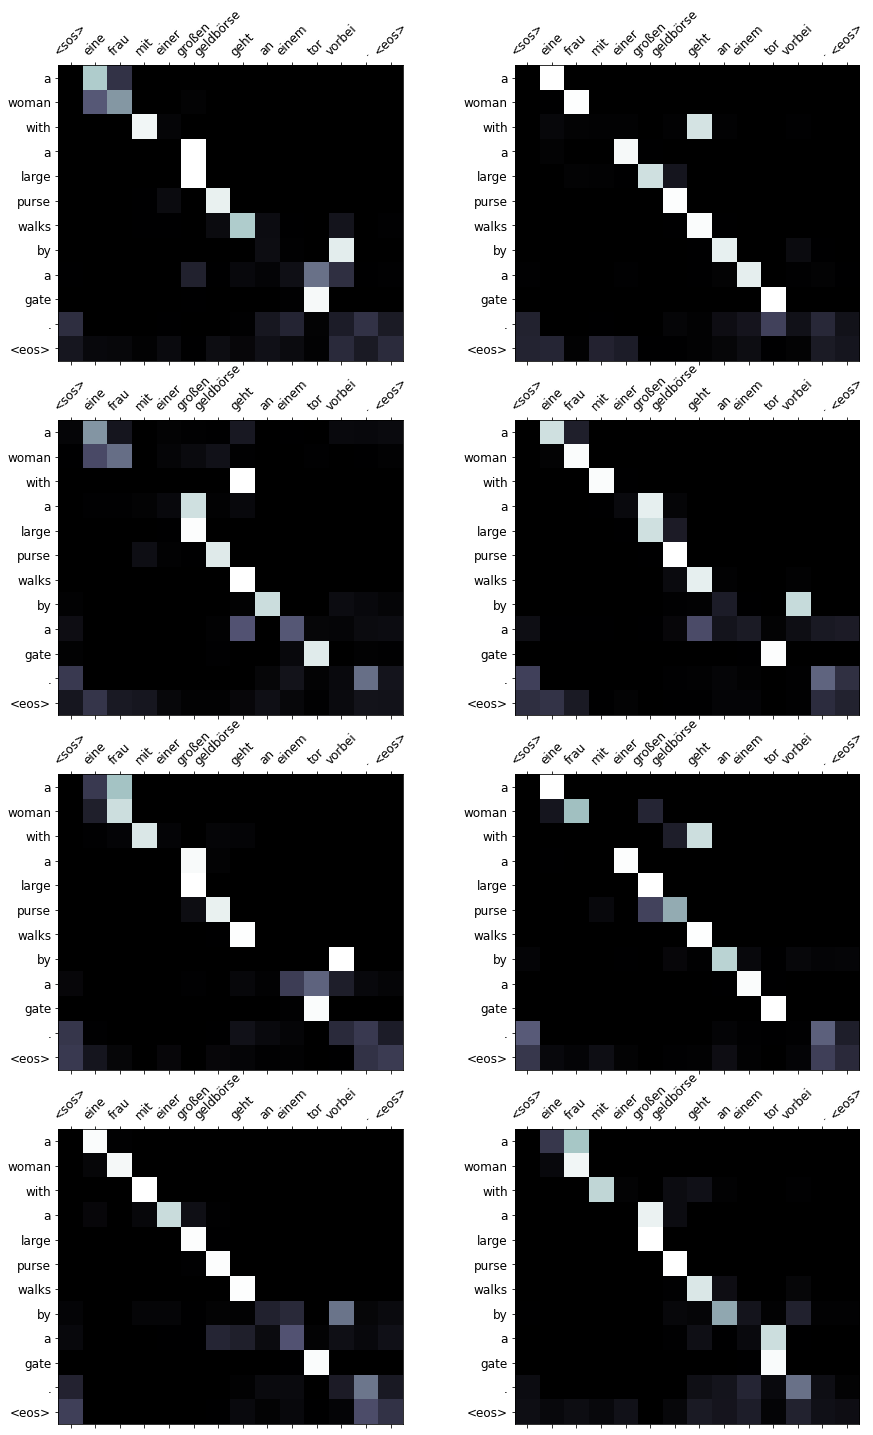

In [ ]:
display_attention(src, translation, attention)


In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


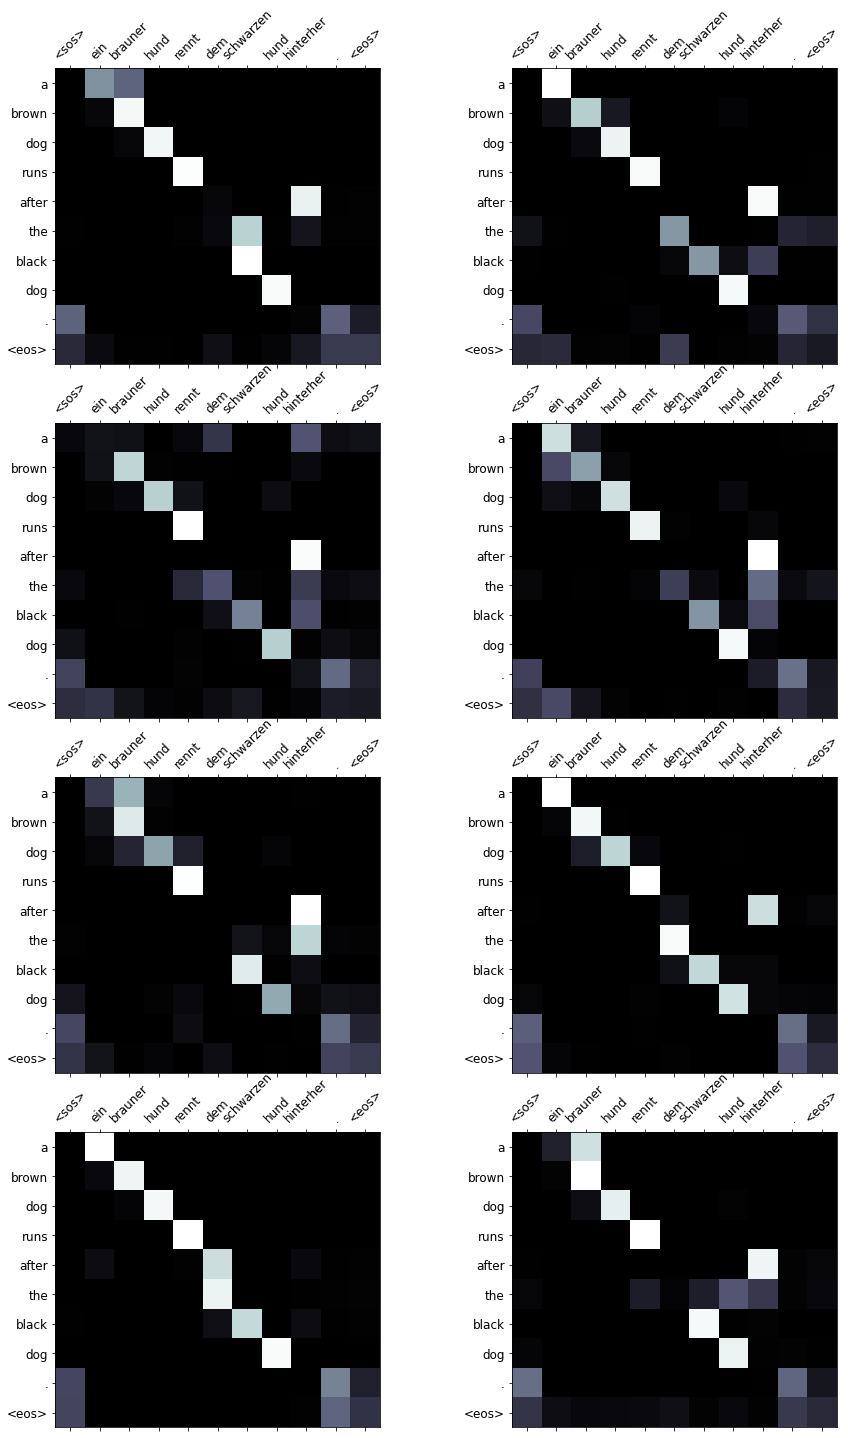

In [ ]:
display_attention(src, translation, attention)


In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'small', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outdoors', '.', '<eos>']


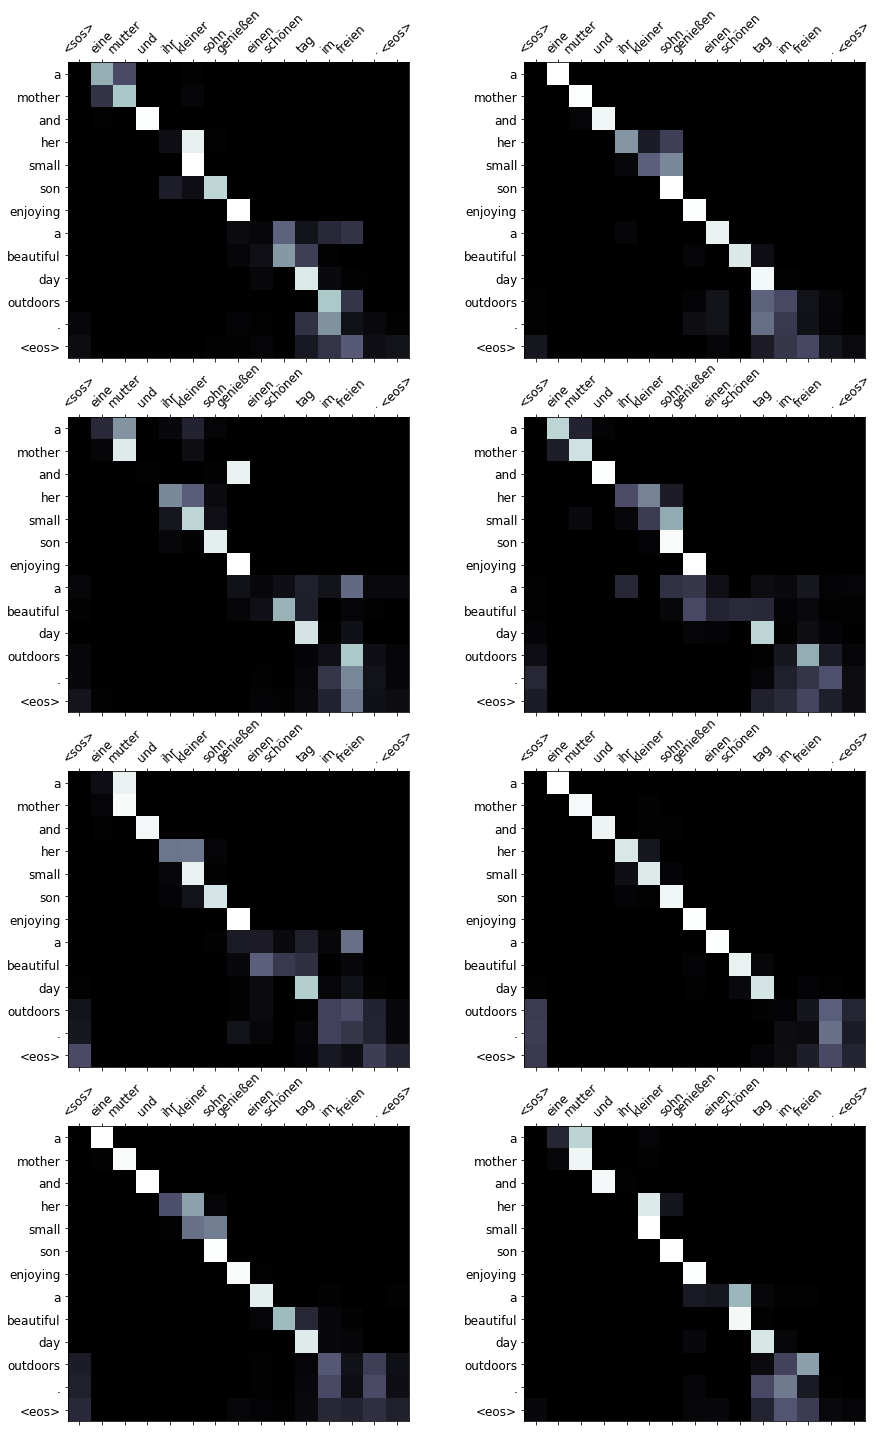

In [ ]:
display_attention(src, translation, attention)


# BLEU Score

The Bilingual Evaluation Understudy Score, or BLEU for short is a method for automatic evaluation of machine translation. BLEU is a score for comparing/evaluating a candidate translation (translated sentence) of text to one or more reference translation (ground truth). 
It is based on "text string matches" i.e it quantifies how good a machine translation by computing a similarity score based on ngram precision.

BLEU score can also be used to evalutate a wide range of text generation NLP tasks like language generation, image caption generation, text summarization etc.

Few benefits of BLEU score:
  - Quick and inexpensive to calculate
  - easy to understand
  - language independent


BLEU metrics ranges from 0 to 1. The higher the BLEU Score the better.



In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.09
